In [1]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(stringr)
library(tidyr)
theme_set(theme_bw())
options(repr.plot.width=7, repr.plot.height=4)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



# Introduction

In [clade-freqs](clade-freqs.ipynb), I've annotated a list of identity elements that appear to be conserved in over 95% of tRNAs. Some of these are reflected in the literature; others are not. I expect that the well-studied IDEs that are agreed to be universal to hold true. Thus, I need to look into the tRNAs that *don't* have this IDE. 

Do these exceptions function as tRNAs? Using a suite of supposedly gold standard IDEs, we would expect to be able to differentiate between bona fide tRNAs and tRNA pseudogenes.

I'll get a set of tRNAs that may or may not be missing a key IDE. I'll then proceed in two branches. 
1) IDE rules. We've learned something about which IDEs are required. We now know how to choose canonical tRNAs. Filter based on these IDEs or based on suites of IDEs, regenerate frequencies, rinse and repeat.
2) Interesting exceptions to the rule. Some tRNAs are exceptional. Look deeply into a few examples where they're missing a key IDE. Are any of them functional? Are they missing all of the other IDEs?
 
#2 is easier to tackle first, as we isolate the tRNAs. First, we'll recreate the frequency table.

# Data wrangling

## Import alignment and bases


In [2]:
identities = read.delim('identities.tsv', sep='\t', stringsAsFactors=FALSE)
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)

In [3]:
positions = colnames(identities)[which(str_detect(colnames(identities), "X\\d+\\.\\d+$"))]
positions = c(positions, 'X8', 'X9', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X20a', 'X21', 'X26', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X44', 'X45', 'X46', 'X47', 'X48', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X73')

## Get frequencies

In [147]:
clade_iso_ac_freqs = identities %>%
  filter(quality & (!restrict | isotype == "iMet")) %>%
  select(match(c('clade', 'isotype', 'anticodon', positions), colnames(identities))) %>%
  gather(positions, bases, -clade, -isotype, -anticodon) %>%
  group_by(clade, isotype, anticodon, positions, bases) %>%
  tally() %>%
  group_by(clade, isotype, anticodon, positions) %>%
  mutate(freq=n) %>%
  group_by(clade, isotype, anticodon, positions) %>%
  summarize(A = sum(freq[bases == "A"]),
            C = sum(freq[bases == "C"]),
            G = sum(freq[bases == "G"]),
            U = sum(freq[bases == "U"]),
            Deletion = sum(freq[bases %in% c("-", ".")]), 
            Purine = sum(freq[bases %in% c("A", "G")]),
            Pyrimidine = sum(freq[bases %in% c("C", "U")]),
            Weak = sum(freq[bases %in% c("A", "U")]),
            Strong = sum(freq[bases %in% c("G", "C")]),
            Amino = sum(freq[bases %in% c("A", "C")]),
            Keto = sum(freq[bases %in% c("G", "U")]),
            B = sum(freq[bases %in% c("C", "G", "U")]),
            D = sum(freq[bases %in% c("A", "G", "U")]),
            H = sum(freq[bases %in% c("A", "C", "U")]),
            V = sum(freq[bases %in% c("A", "C", "G")]),
            D = sum(freq[bases %in% c("A", "G", "U")]),
            GC = sum(freq[bases == "G:C"]),
            AU = sum(freq[bases == "A:U"]),
            UA = sum(freq[bases == "U:A"]),
            CG = sum(freq[bases == "C:G"]),
            GU = sum(freq[bases == "G:U"]),
            UG = sum(freq[bases == "U:G"]),
            PairDeletion = sum(freq[bases == "-:-"]), 
            PurinePyrimidine = sum(freq[bases %in% c("A:U", "G:C")]),
            PyrimidinePurine = sum(freq[bases %in% c("U:A", "C:G")]),
            StrongPair = sum(freq[bases %in% c("G:C", "C:G")]),
            WeakPair = sum(freq[bases %in% c("A:U", "U:A")]),
            Wobble = sum(freq[bases %in% c("G:U", "U:G")]),
            Paired = sum(freq[bases %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G")]),
            Bulge = sum(freq[bases %in% c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U")]),
            Mismatched = sum(freq[bases %in% c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")])
            ) %>%
  mutate(total = A + B + Deletion + Paired + Mismatched + Bulge + PairDeletion) %>%
  melt(id.vars=c("clade", "isotype", "anticodon", "positions", "total")) %>%
  mutate(freq=value/total)

In [211]:
clade_iso_freqs = clade_iso_ac_freqs %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total))

euk_freqs = clade_iso_ac_freqs %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total))

consensus = euk_freqs %>%
  filter(freq > 0.95) %>%
  group_by(positions) %>% # remove duplicates
  filter(row_number(freq) == 1) %>%
  filter(!(positions %in% c("X8", "X14", "X15", "X48", "X18", "X19", "X55", "X56"))) %>%
  arrange(positions)
consensus

,positions,variable,count,freq
1,X10.25,Paired,46359,0.9972465
2,X15.48,Paired,44501,0.957299
3,X16,B,45087,0.9698841
4,X1.72,Paired,46207,0.9944046
5,X18.55,GU,46063,0.9908792
6,X19.56,GC,45915,0.9876955
7,X20,H,44899,0.9658399
8,X21,A,46351,0.9970745
9,X26,D,44787,0.9634306
10,X2.71,Paired,44417,0.955677


# Analysis of eukaryotic all-tRNA consensus identity elements

## 2:71

This one is not mentioned in M&G often, but they do note a dependency for alanine. Giegé lists C2:G71 for glycine.

It seems like 2:71 is typically a strong pair, perhaps to strengthen the acceptor stem.

In [196]:
clade_iso_ac_freqs %>% filter(positions == 'X2.71') %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.8) %>% filter(row_number(freq) == 1 & variable != "Paired")

,positions,isotype,variable,count,freq
1,X2.71,Ala,GC,3260,0.9848943
2,X2.71,Asn,PyrimidinePurine,1436,0.8210406
3,X2.71,Asp,CG,1592,0.8295987
4,X2.71,Cys,GC,1770,0.9325606
5,X2.71,Gln,Mismatched,1846,0.9951482
6,X2.71,Glu,CG,2499,0.9857988
7,X2.71,Gly,CG,3017,0.9556541
8,X2.71,His,CG,956,0.8342059
9,X2.71,Ile,StrongPair,2139,0.9807428
10,X2.71,iMet,GC,1040,0.8881298



## 3:70

M&G: Even numbers across all pairs, 9 mismatches. G3-U70 unique to Ala. A few other isotypes have single exceptions. Antideterminant for Thr. C3-G70 positive for iMet. Dependent on 2-71 context.

First, let's check the iMet frequencies. 

In [150]:
clade_iso_ac_freqs %>% filter(positions == 'X3.70' & isotype == "iMet") %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.05)

,positions,isotype,variable,count,freq
1,X3.70,iMet,CG,1171,0.9991468
2,X3.70,iMet,PyrimidinePurine,1171,0.9991468
3,X3.70,iMet,StrongPair,1171,0.9991468
4,X3.70,iMet,Paired,1172,1


M&G's frequencies with iMet are confirmed. This is a pretty strong determinant for initiator methionine.

For alanine, previous work (e.g. with [Chihade et al. 1998](http://pubs.acs.org/doi/pdf/10.1021/bi9804636)) shows that G3-U70 is a strong determinant in *C. elegans*. M&G do find that a few other tRNAs also contain G3-U70. [Beuning et al. 2002](http://rnajournal.cshlp.org/content/8/5/659.full.pdf) also shows that the orientation of a 2:71 purine:pyrimidine pair is helpful for charging. Let's see if G3-U70 is specifically enriched in alanine.

In [156]:
clade_iso_ac_freqs %>% filter(positions == 'X3.70' & variable == "GU") %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.001)

,positions,isotype,variable,count,freq
1,X3.70,Ala,GU,3199,0.9664653
2,X3.70,Cys,GU,11,0.005795574
3,X3.70,Gly,GU,15,0.004751346


This basically confirms M&G's (non-)conclusions - GU is enriched for Ala, though no recriprocal relationship exists, except for Ala-NGC.

## U8-A14

This is known to be extremely conserved, since it stabilizes the tertiary structure. M&G found that a variety of bacteria and archaea contain a C8 variation. Our data fits the eukaryotic side of things at 97%.

## R9 and 9:23

M&G: mostly a purine here. Interacts with base 23 in class I tRNAs. 

Our data supports this, and goes a step further in class II tRNAs, where it's a G9. The 9-23 interaction is not restricted to a particular interaction in any way, which agrees with my previous [tertiary interactions analysis](../tertiary-interactions.ipynb), where I proposed that it is an isotype- and clade-specific IDE. As for fungi, it would appear that the 9:23 interaction exhibits more pairing behavior, but is still typically mismatched as in other clades. Then again, it's not even listed as part of the consensus IDEs found above.

In [158]:
clade_iso_ac_freqs %>% filter(!(isotype %in% c("Ser", "Leu")) & positions %in% c('X9', 'X9.23')) %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>% filter(row_number(freq) == 1)

clade_iso_ac_freqs %>% filter(isotype %in% c("Ser", "Leu") & positions %in% c('X9', 'X9.23')) %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>% filter(row_number(freq) == 1)

clade_iso_ac_freqs %>% filter(positions == 'X9.23') %>%
  group_by(positions, clade, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.1)

,positions,variable,count,freq
1,X9,Purine,39055,0.9764482
2,X9.23,Mismatched,36234,0.9059179


,positions,variable,count,freq
1,X9,G,6466,0.996302
2,X9.23,Mismatched,6204,0.9559322


,positions,clade,variable,count,freq
1,X9.23,Fungi,GU,1099,0.1014774
2,X9.23,Fungi,Wobble,1099,0.1014774
3,X9.23,Fungi,Paired,1578,0.1457064
4,X9.23,Fungi,Mismatched,9252,0.8542936
5,X9.23,Insecta,Mismatched,900,0.9018036
6,X9.23,Mammalia,Mismatched,13300,0.9410599
7,X9.23,Nematoda,Mismatched,3639,0.9321209
8,X9.23,Spermatophyta,Paired,207,0.1212654
9,X9.23,Spermatophyta,Mismatched,1500,0.8787346
10,X9.23,Streptophyta,Paired,508,0.104141


## 10:25

M&G: 10/41 GC, 31/41 GU, positive determinant for yeast Asp, negative determinant for yeast M22G on 26, interacts with 45.

This is pretty par for the course. Our data show that GC $\approx$ 75% is more common though (GU $\approx$ 22%).

In [159]:
euk_freqs %>% filter(positions == 'X10.25' & freq > 0.1)

,positions,variable,count,freq
1,X10.25,GC,34254,0.7368512
2,X10.25,GU,11262,0.2422613
3,X10.25,PurinePyrimidine,34372,0.7393895
4,X10.25,StrongPair,34554,0.7433046
5,X10.25,Wobble,11264,0.2423043
6,X10.25,Paired,46359,0.9972465


## A14

This is an invariant position, mentioned in M&G, involved in U8:A14.

## R15, 15:48

This is the Levitt base pair. M&G note that this usually forms R15:Y48, but has been shown in *E. coli* to tolerate different combinations. Our data show support for a R15:Y48 requirement.

In [160]:
clade_iso_ac_freqs %>% filter(positions == "X15.48") %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.1)

,positions,variable,count,freq
1,X15.48,GC,36600,0.7873338
2,X15.48,AU,7482,0.1609517
3,X15.48,PurinePyrimidine,44082,0.9482855
4,X15.48,StrongPair,36600,0.7873338
5,X15.48,WeakPair,7482,0.1609517
6,X15.48,Paired,44501,0.957299


## B16

In M&G, 16 is most commonly a U. There's lower conservation here. This position is commonly modified to a D, so a U makes sense. But it's also strange that a position thought to be important for synthetase recognition doesn't exhibit strong conservation. The same goes for position 17.

In [201]:
clade_iso_ac_freqs %>% filter(positions %in% c('X16')) %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "C", "G", "U"))

,positions,variable,count,freq
1,X16,A,1397,0.03005141
2,X16,C,6193,0.13322
3,X16,G,2674,0.05752146
4,X16,U,36220,0.7791426


## G18:U55, 19:56

M&G: G18:U55, G19 in eukaryotes. G19:U56 is common enough. Data shows invariant G19:C56 in eukaryotes. 4 bases downstream from 14 is always a G - so what they were trying to say was a conserved G18. 

They locked in the search strategy to require G18 and R19, and our data doesn't show otherwise.

In [163]:
clade_iso_ac_freqs %>% filter(positions %in% c("X18.55", "X19.56")) %>%
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.1) %>%
  group_by(positions) %>% # remove duplicates
  filter(row_number(freq) == 1)

,positions,variable,count,freq
1,X18.55,GU,46063,0.9908792
2,X19.56,GC,45915,0.9876955


## H20

M&G: Mostly U. G20 is exclusive to Phe-GAA, and vice versa, barring 1 exception.

This base is almost certainly involved in 3d structure, whether as a spacer or stacking nucleotide. Our data shows many tRNAs that don't have a U. G20 does seem to be conserved in Phe-GAA too. It also looks like A20 in arginine is fairly well conserved with respect to the other isotypes.

In [165]:
clade_iso_ac_freqs %>% filter(positions %in% c("X20")) %>% group_by(positions, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "G", "C", "U"))

clade_iso_ac_freqs %>% filter(positions %in% c("X20")) %>% group_by(positions, isotype, anticodon, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "G", "C") & freq > 0.5 & count > 10)

clade_iso_ac_freqs %>% filter(positions %in% c("X20") & isotype == "Arg") %>% group_by(positions, isotype, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "G", "C", "U"))

,positions,variable,count,freq
1,X20,A,4035,0.08679846
2,X20,C,3063,0.06588939
3,X20,G,1588,0.03416009
4,X20,U,37801,0.8131521


,positions,isotype,anticodon,variable,count,freq
1,X20,Arg,ACG,A,693,0.6985887
2,X20,Arg,CCG,A,258,0.8628763
3,X20,Arg,CCT,A,436,0.8466019
4,X20,Arg,TCG,A,484,0.75625
5,X20,Arg,TCT,A,578,0.6963855
6,X20,iMet,CAT,A,1102,0.940273
7,X20,Met,CAT,C,753,0.6681455
8,X20,Phe,GAA,G,1391,0.9802678


,positions,isotype,variable,count,freq
1,X20,Arg,A,2449,0.747558
2,X20,Arg,C,389,0.1187424
3,X20,Arg,G,1,0.0003052503
4,X20,Arg,U,437,0.1333944


## A21

M&G: A21 is invariant except for G21 in Met-CAT in *S. pombe*.

This base stacks with 8:14. However, I don't see G21 at all. 

In [166]:
clade_iso_ac_freqs %>% filter(positions == "X21") %>% group_by(positions, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>% filter(freq > 0.5) %>% filter(row_number(freq) == 1)

clade_iso_ac_freqs %>% filter(positions == "X21") %>% group_by(positions, clade, isotype, anticodon, variable)%>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>% filter(clade == "Fungi" & isotype == "Met" & variable %in% c("U", "G", "C", "A"))

,positions,variable,count,freq
1,X21,A,46351,0.9970745


,positions,clade,isotype,anticodon,variable,count,freq
1,X21,Fungi,Met,CAT,A,209,1
2,X21,Fungi,Met,CAT,C,0,0
3,X21,Fungi,Met,CAT,G,0,0
4,X21,Fungi,Met,CAT,U,0,0


Digging in more deeply, the *S. pombe* tRNAs score poorly, and align better to the threonine CM. Previously, the alignment has U20-G20a-G21. However, the alignment places a gap at 21 and 22, and places the insertion before 20a.

This is an exceedingly rare exception - almost all other tRNAs have this aligned properly, as shown in [euk-tRNAs](../euk-tRNAs.ipynb). 

In [93]:
identities[identities$clade == "Fungi" & identities$isotype_ac == "Met" & identities$species == "schiPomb_972H", ]

,clade,domain,isotype,seqname,species,species_long,isotype_ac,anticodon,score,isoscore,GC,D.loop,AC.loop,TPC.loop,V.arm,intron,insertions,deletions,quality,restrict,X0i1,X0i2,X0i3,X0i4,X0i5,X0i6,X0i7,X0i8,X0i9,X0i10,X0i11,X1.72,X1,X1i1,X2.71,X2,X2i1,X3.70,X3,X3i1,X3i2,X3i3,X3i4,X3i5,X3i6,X3i7,X4.69,X4,X4i1,X4i2,X4i3,X4i4,X4i5,X4i6,X4i7,X4i8,X4i9,X4i10,X4i11,X5.68,X5,X5i1,X5i2,X5i3,X5i4,X5i5,X5i6,X5i7,X6.67,X6,X6i1,X7.66,X7,X7i1,X7i2,X7i3,X7i4,X7i5,X7i6,X7i7,X7i8,X7i9,X7i10,X7i11,X7i12,X7i13,X7i14,X8,X8.14.21,X8.14,X8i1,X8i2,X8i3,X8i4,X9,X9.12.23,X9.23,X9i1,X9i2,X9i3,X10.25,X10,X10.25.45,X10.45,X10i1,X11.24,X11,X12.23,X12,X12i1,X12i2,X12i3,X12i4,X13.22,X13,X13.22.46,X13i1,X14,X14i1,X14i2,X14i3,X14i4,X14i5,X14i6,X14i7,X14i8,X14i9,X14i10,X14i11,X14i12,X14i13,X14i14,X14i15,X14i16,X14i17,X14i18,X14i19,X14i20,X14i21,X14i22,X14i23,X14i24,X14i25,X15,X15.48,X16,X16i1,X16i2,X16i3,X16i4,X16i5,X16i6,X16i7,X16i8,X16i9,X16i10,X16i11,X16i12,X16i13,X16i14,X16i15,X16i16,X16i17,X16i18,X16i19,X16i20,X17,X17i1,X17i2,X17i3,X18,X18.55,X19,X19.56,X20,X20i1,X20i2,X20i3,X20i4,X20i5,X20i6,X20i7,X20i8,X20i9,X20i10,X20a,X20b,X21,X21i1,X22,X22.46,X22i1,X23,X23i1,X24,X24i1,X25,X25i1,X25i2,X25i3,X25i4,X25i5,X25i6,X25i7,X25i8,X25i9,X25i10,X25i11,X25i12,X25i13,X26,X26.44,X26i1,X26i2,X26i3,X26i4,X27.43,X27,X27i1,X27i2,X27i3,X27i4,X27i5,X28.42,X28,X28i1,X28i2,X28i3,X28i4,X29.41,X29,X29i1,X30.40,X30,X30i1,X31.39,X31,X32,X33,X34,X35,X35i1,X36,X37,X37i1,X37i2,X37i3,X37i4,X37i5,X37i6,X37i7,X37i8,X37i9,X37i10,X37i11,X37i12,X37i13,X37i14,X37i15,X37i16,X37i17,X37i18,X37i19,X37i20,X37i21,X37i22,X37i23,X37i24,X37i25,X37i26,X37i27,X37i28,X37i29,X37i30,X37i31,X37i32,X37i33,X37i34,X37i35,X37i36,X37i37,X37i38,X37i39,X37i40,X37i41,X37i42,X37i43,X37i44,X37i45,X37i46,X37i47,X37i48,X37i49,X37i50,X37i51,X37i52,X37i53,X37i54,X37i55,X37i56,X37i57,X37i58,X37i59,X37i60,X37i61,X37i62,X37i63,X37i64,X37i65,X37i66,X37i67,X37i68,X37i69,X37i70,X37i71,X37i72,X37i73,X37i74,X37i75,X37i76,X37i77,X37i78,X37i79,X37i80,X37i81,X37i82,X37i83,X37i84,X37i85,X37i86,X37i87,X37i88,X37i89,X37i90,X37i91,X37i92,X37i93,X37i94,X37i95,X37i96,X37i97,X37i98,X37i99,X37i100,X37i101,X37i102,X37i103,X37i104,X37i105,X37i106,X37i107,X37i108,X37i109,X37i110,X37i111,X37i112,X37i113,X37i114,X37i115,X37i116,X37i117,X37i118,X37i119,X37i120,X37i121,X37i122,X37i123,X37i124,X37i125,X37i126,X37i127,X37i128,X37i129,X37i130,X37i131,X37i132,X37i133,X37i134,X37i135,X37i136,X37i137,X37i138,X37i139,X37i140,X37i141,X37i142,X37i143,X37i144,X37i145,X37i146,X37i147,X37i148,X37i149,X37i150,X37i151,X37i152,X37i153,X37i154,X37i155,X37i156,X37i157,X37i158,X37i159,X37i160,X37i161,X37i162,X37i163,X37i164,X37i165,X37i166,X37i167,X37i168,X37i169,X37i170,X37i171,X37i172,X37i173,X37i174,X37i175,X37i176,X37i177,X37i178,X37i179,X37i180,X37i181,X37i182,X37i183,X37i184,X37i185,X37i186,X37i187,X37i188,X37i189,X37i190,X37i191,X37i192,X37i193,X37i194,X37i195,X37i196,X37i197,X37i198,X37i199,X37i200,X37i201,X37i202,X37i203,X37i204,X37i205,X37i206,X37i207,X37i208,X37i209,X37i210,X37i211,X37i212,X37i213,X37i214,X37i215,X37i216,X37i217,X37i218,X37i219,X37i220,X37i221,X37i222,X37i223,X37i224,X37i225,X37i226,X37i227,X37i228,X37i229,X37i230,X37i231,X37i232,X37i233,X37i234,X37i235,X37i236,X37i237,X37i238,X37i239,X37i240,X37i241,X37i242,X37i243,X37i244,X37i245,X37i246,X37i247,X37i248,X37i249,X37i250,X37i251,X37i252,X37i253,X37i254,X37i255,X37i256,X37i257,X37i258,X37i259,X37i260,X37i261,X37i262,X37i263,X37i264,X37i265,X37i266,X37i267,X37i268,X37i269,X37i270,X37i271,X37i272,X37i273,X37i274,X37i275,X37i276,X37i277,X37i278,X37i279,X37i280,X37i281,X37i282,X37i283,X37i284,X37i285,X37i286,X37i287,X37i288,X37i289,X37i290,X37i291,X37i292,X37i293,X37i294,X37i295,X37i296,X37i297,X37i298,X37i299,X37i300,X37i301,X37i302,X37i303,X37i304,X37i305,X37i306,X37i307,X37i308,X37i309,X37i310,X37i311,X37i312,X37i313,X37i314,X37i315,X37i316,X37i317,X37i318,X37i319,X37i320,X37i321,X37i322,X37i323,X37i324,X37i325,X37i326,X37i327,X37i328,X37i329,X37i330,X37i331,X37i332,X37i333,X37i334,X3

## D26, D44, 26:44

M&G don't say much about this. Our data show a near-universal consensus for anything but C at these positions. In [tertiary-interactions](../tertiary-interactions.ipynb) I show that this is most commonly G26:A44 (about half of tRNAs), but it's not a strong identity element.

## 27:43

## Y32, H38

M&G: WC pairs rare at 32:38, but there tends to be a weak pairing here for a more stable AC stem-loop. Auffinger and Westhof (1999) showcase a variety of weak pairings (e.g., single hydrogen bond).

Giegé lists C38 as a determinant for Asp across the domains. This is confirmed, but clearly a ton of other tRNAs also have a conserved position 38.

In [167]:
clade_iso_ac_freqs %>% filter(positions %in% c("X32", "X38")) %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.95 | variable %in% c("A", "C", "G", "U"))

clade_iso_ac_freqs %>% filter(positions == "X38") %>% 
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.95 & variable %in% c("A", "C", "G", "U"))

,positions,variable,count,freq
1,X32,A,32,0.0006883645
2,X32,C,32947,0.7087358
3,X32,G,55,0.001183126
4,X32,U,13453,0.2893927
5,X32,Pyrimidine,46400,0.9981285
6,X32,B,46455,0.9993116
7,X32,H,46432,0.9988169
8,X38,A,26934,0.5793878
9,X38,C,10835,0.2330759
10,X38,G,42,0.0009034784


,positions,isotype,variable,count,freq
1,X38,Asn,A,1744,0.9971412
2,X38,Asp,C,1911,0.9958312
3,X38,Cys,A,1868,0.9841939
4,X38,Glu,C,2508,0.9893491
5,X38,His,C,1107,0.9659686
6,X38,Ile,A,2174,0.9967905
7,X38,iMet,A,1172,1
8,X38,Lys,A,3105,0.9967897
9,X38,Met,A,1123,0.9964508
10,X38,Phe,A,1378,0.9711064


## U33

M&G: Strong U33 IDE. Exceptions exist. This is reflected clearly in our data.

## R37

34, 35, and 36 are the anticodon, and 37 is known as the base before the intron. Thus, it should be conserved as it is needed for splice site recognition. M&G note that it is almost always a purine. Giegé et al. list Leu-G37 and Phe-A37 as determinants. While Giegé et al. are correct about Leu-G37, Phenylalanine typically contains G37 too. Like with position 38, many other isotypes have their own preferences, with 15 above 95% frequency.

Overall, our data show that 70% of the time, it's an A, only slightly higher than in M&G, where the ratio was closer to 2:1. 

In [168]:
clade_iso_ac_freqs %>% filter(positions == "X37") %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U"))

clade_iso_ac_freqs %>% filter(positions == "X37") %>% 
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U") & freq > 0.9)

,positions,variable,count,freq
1,X37,A,32353,0.695958
2,X37,C,27,0.0005808075
3,X37,G,14085,0.3029879
4,X37,U,22,0.0004732506


,positions,isotype,variable,count,freq
1,X37,Ala,A,3303,0.9978852
2,X37,Asn,A,1746,0.9982847
3,X37,Cys,G,1739,0.9162276
4,X37,Gln,A,1854,0.9994609
5,X37,Glu,A,2524,0.9956607
6,X37,Gly,A,3154,0.9990497
7,X37,His,G,1145,0.9991274
8,X37,Ile,A,2105,0.9651536
9,X37,iMet,A,1172,1
10,X37,Leu,G,3216,0.9950495


## R46, Y48

These two are relatively unknown and not talked about. Could be new identity elements. What could 46/48 be used for? A long variable loop exists in Type II tRNAs and is surmised to happen at position 47. 

In [169]:
clade_iso_ac_freqs %>% filter(positions %in% c("X46", "X48")) %>%
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U"))

,positions,variable,count,freq
1,X46,A,6464,0.1390496
2,X46,C,47,0.001011035
3,X46,G,39711,0.8542388
4,X46,U,241,0.005184245
5,X48,A,995,0.02140429
6,X48,C,37456,0.805748
7,X48,G,133,0.002861076
8,X48,U,7899,0.1699221


There's a difference between Type I and Type II tRNAs here. Something fishy is going on...

In [175]:
clade_iso_ac_freqs %>% filter(positions %in% c("X46", "X48")) %>%
  mutate(Type=ifelse(isotype %in% c("Ser", "Leu"), "II", "I")) %>%
  group_by(positions, Type, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U") & freq > 0.5)

,positions,Type,variable,count,freq
1,X46,I,G,33535,0.8384379
2,X46,II,G,6176,0.9516179
3,X48,I,C,31045,0.7762026
4,X48,II,C,6411,0.9878274


## 49:65, 53:61

M&G: The stem after 49:65 is enriched for G-C pairs. G53:C61 is the canonical base pair here, though others, especially A53:U61 are sometimes observed.

I would not characterize G53:C61 as "highly conserved" as they do. A G-U pair is evidently acceptable in 35% of tRNAs.

In [180]:
clade_iso_ac_freqs %>% 
  filter(positions %in% c("X49.65", "X53.61")) %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.1)

,positions,variable,count,freq
1,X49.65,GC,16630,0.3577498
2,X49.65,CG,22478,0.4835538
3,X49.65,PurinePyrimidine,19477,0.4189954
4,X49.65,PyrimidinePurine,23288,0.5009788
5,X49.65,StrongPair,39108,0.8413036
6,X49.65,Paired,46199,0.9938475
7,X53.61,GC,28405,0.6110442
8,X53.61,GU,16661,0.358409
9,X53.61,PurinePyrimidine,28437,0.6117326
10,X53.61,StrongPair,28405,0.6110442


## U54, A58, 54:58

Base 54 is what the T$\Psi$C loop is named for. Nothing surprising here. M&G note some exceptions, such as in initiator methionine, so our frequencies are listed below.

Base 58 is typically modified into m$^1$A, so this is also expected to be conserved. M&G claim there is no exception to A58. As with many of the previously determined "consensus" identity elements, the exceptions found in our data may be tRNAs that sneaked past our quality, species restricted, and score filters.


In [189]:
clade_iso_ac_freqs %>% filter(positions %in% c("X54", "X58", "X54.58")) %>% 
  mutate(Type=ifelse(isotype == "iMet", "Initiator", "Elongator")) %>%
  group_by(positions, Type, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9) %>% filter(row_number(freq) == 1)

,positions,Type,variable,count,freq
1,X54,Elongator,U,44250,0.9764978
2,X54,Initiator,A,1169,0.9974403
3,X54.58,Elongator,UA,44066,0.9724588
4,X54.58,Initiator,Mismatched,1170,0.9982935
5,X58,Elongator,A,45119,0.9956967
6,X58,Initiator,A,1172,1


## U55, V56, R57

M&G: Mostly U55, and locked to Y. Mostly C56. R57. Our data mostly agrees with this.

## H60

M&G: Pretty variable, but A60 (and A54) is an identity element for iMet-CAT.

It seems like it's typically a U (60%) or C (30%). 

In [184]:
clade_iso_ac_freqs %>% filter(positions == "X60") %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9)

clade_iso_ac_freqs %>% filter(isotype == "iMet" & positions == "X60") %>% 
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9)

,positions,variable,count,freq
1,X60,Pyrimidine,43146,0.9281304
2,X60,B,43639,0.9387356
3,X60,H,45977,0.9890292


,positions,isotype,variable,count,freq
1,X60,iMet,A,1171,0.9991468
2,X60,iMet,Purine,1171,0.9991468
3,X60,iMet,Weak,1171,0.9991468
4,X60,iMet,Amino,1172,1
5,X60,iMet,D,1171,0.9991468
6,X60,iMet,H,1172,1
7,X60,iMet,V,1172,1


## Non-consensus identity elements

There's plenty of examples where our frequencies confirm known rules, supplant known rules, or indicate new rules. There's also plenty of rules that weren't recapitulated above - and those are worth looking into individually.

## C1:G72

## C5:G68

# No. tRNAs by missing IDEs

In [313]:
missed = identities %>% mutate(X10.25 = X10.25 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X15.48 = X15.48 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X16 = X16 %in% c("G", "C", "U"),
                               X1.72 = X1.72 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X18.55 = X18.55 == "G:U",
                               X19.56 = X19.56 == "G:C",
                               X20 = X20 %in% c("A", "C", "U"),
                               X21 = X21 == "A",
                               X26 = X26 %in% c("A", "G", "U"),
                               X2.71 = X2.71 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X27.43 = X27.43 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X32 = X32 %in% c("C", "U"),
                               X33 = X33 == "U",
                               X37 = X37 %in% c('A', 'G'),
                               X3.70 = X3.70 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X38 = X38 %in% c("A", "C", "U"),
                               X46 = X46 %in% c('A', 'G'),
                               X49.65 = X49.65 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X53.61 = X53.61 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X54 = X54 == "U",
                               X57 = X57 %in% c('A', 'G'),
                               X58 = X58 == "A",
                               X60 = X60 %in% c("A", "C", "U"),
                               X8.14 = X8.14 == "U:A",
                               X9 = X9 %in% c("A", "G")) %>%
  mutate(Missed=25 - (X10.25 + X15.48 + X16 + X1.72 + X18.55 + X19.56 + X20 + X21 + X26 + X2.71 + X27.43 + X32 + X33 + X37 + X3.70 + X38 + X46 + X49.65 + X53.61 + X54 + X57 + X58 + X60 + X8.14 + X9)) %>%
  mutate(quality=ifelse(quality, "Quality set", "tRNAs > 50 bits"))

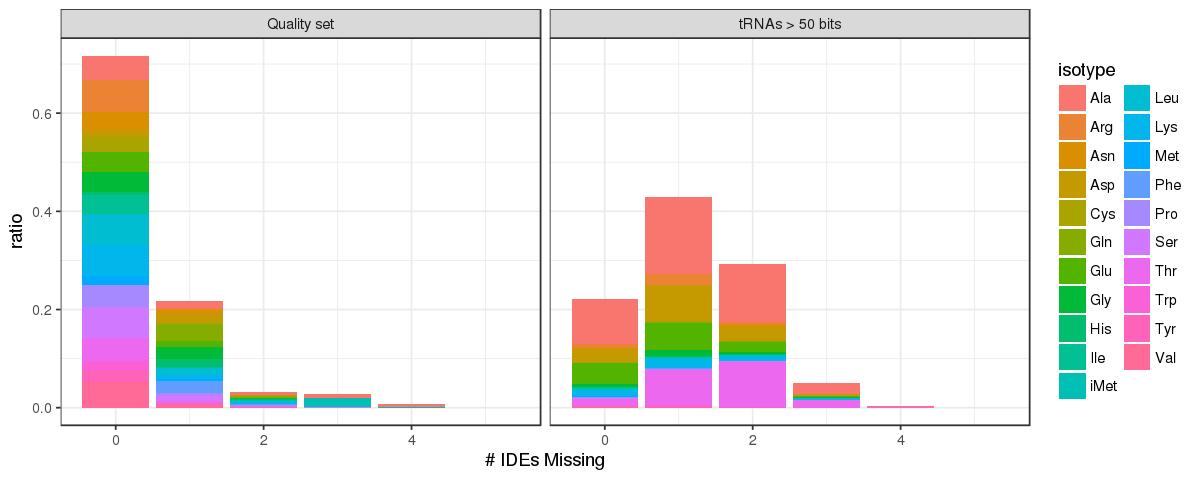

In [334]:
options(repr.plot.width=10, repr.plot.height=4)
missed %>% select(isotype, quality, Missed) %>%
  group_by(quality) %>%
  mutate(sum=length(quality)) %>%
  group_by(isotype, quality, Missed) %>%
  summarize(ratio=length(isotype)/sum[1]) %>%
  ggplot() + geom_bar(aes(x=Missed, y=ratio, fill=isotype), stat='identity') + facet_wrap(~ quality) + xlab("# IDEs Missing")
#ggplot(missed) + geom_bar(aes(x=Missed, fill=isotype)) + xlab("# IDEs Missing") + facet_wrap(~ quality)

What are the most common IDEs that are missed?

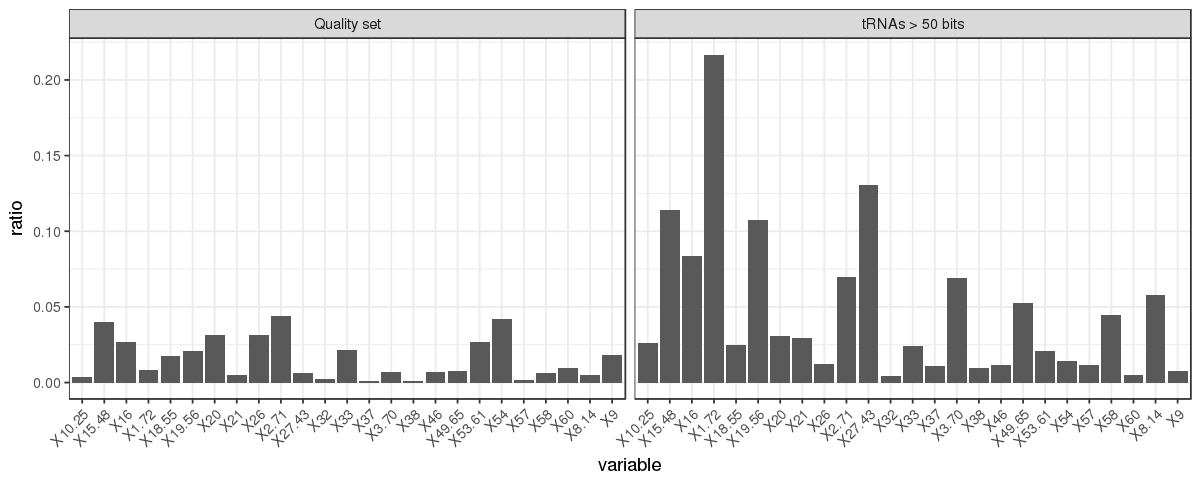

In [314]:
consensus_positions = c('X10.25', 'X15.48', 'X16', 'X1.72', 'X18.55', 'X19.56', 'X20', 'X21', 'X26', 'X2.71', 'X27.43', 'X32', 'X33', 'X37', 'X3.70', 'X38', 'X46', 'X49.65', 'X53.61', 'X54', 'X57', 'X58', 'X60', 'X8.14', 'X9')
missed %>% select(isotype, quality, one_of(consensus_positions)) %>% 
  melt(id.vars=c('isotype', 'quality')) %>% 
  group_by(variable, quality) %>%
  mutate(sum=length(value)) %>%
  group_by(isotype, variable, quality) %>%
  summarize(ratio=sum(!value)/sum[1]) %>%
  ggplot() + geom_bar(aes(x=variable, y=ratio), stat='identity') + theme(axis.text.x=element_text(angle=45, hjust=1)) + facet_wrap(~ quality)

The y-axis here is the percentage of tRNAs for a IDE that don't contain the IDE. The left side is a script quality check - did I parse the tRNAs correctly? Since all of the IDE misses are under 5%, it is.

Taken together, these two graphs indicate that the quality set - tRNAs that are more likely to be bona fide tRNAs - 